# Graph Neural Networks for Mental Health Prediction
# A Comparison of GCN, GraphSAGE, and GAT Models on mental health

This notebook implements and compares different Graph Neural Network architectures
for predicting mental health states based on social media usage patterns.

Features included:
- Multiple GNN architectures (GCN, GraphSAGE, GAT)
- Comprehensive visualization suite
- Model performance comparison framework
- Advanced graph analysis and embeddings visualization

In [1]:
#@title  1: Install Required Libraries
"""
Install all necessary libraries for the experiment.
Run this cell first in a new environment.
"""

%pip install torch-geometric

# !pip install torch torchvision torchaudio torch-geometric scikit-learn pandas numpy matplotlib seaborn transformers wordcloud plotly networkx kagglehub umap-learn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 183.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 409.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install pandas numpy matplotlib seaborn plotly networkx scikit-learn torch torchvision torchaudio torch-geometric kagglehub umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 376.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 224.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 285.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 396.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 316.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 300.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 351.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 223.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
#@title  2: Import Libraries and Setup
"""
Import all required libraries and set up the environment for reproducible results.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PyTorch and PyTorch Geometric
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx

# Machine Learning utilities
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Data loading
import kagglehub

# Dimensionality reduction
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available. Using PCA and t-SNE only.")

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎯 All libraries imported successfully!")
print(f"📊 PyTorch version: {torch.__version__}")
print(f"🔧 Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


🎯 All libraries imported successfully!
📊 PyTorch version: 2.8.0.dev20250319+cu128
🔧 Device available: CUDA


In [2]:

#@title  3: Data Loading and Initial Exploration
"""
Load the mental health dataset and perform initial data exploration.
"""
def load_and_explore_data():
    """
    Load the social media mental health dataset and display basic information.

    Returns:
        pd.DataFrame: The loaded dataset
    """
    print(" Downloading dataset from Kaggle...")
    souvikahmed071_social_media_and_mental_health_path = kagglehub.dataset_download(
        'souvikahmed071/social-media-and-mental-health'
    )
    print(f'Data source import complete.: {souvikahmed071_social_media_and_mental_health_path}')

    # Load the dataset
    df = pd.read_csv(f"{souvikahmed071_social_media_and_mental_health_path}/smmh.csv")

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
    print(f"Missing values: {df.isnull().sum().sum()}")

    return df

# Load the dataset
df = load_and_explore_data()
df

Data source import complete.: /root/.cache/kagglehub/datasets/souvikahmed071/social-media-and-mental-health/versions/15
Dataset shape: (481, 21)
Columns: 21
Missing values: 30


,Timestamp,1. What is your age?,2. Gender,3. Relationship Status,4. Occupation Status,5. What type of organizations are you affiliated with?,6. Do you use social media?,7. What social media platforms do you commonly use?,8. What is the average time you spend on social media every day?,9. How often do you find yourself using Social media without a specific purpose?,...,11. Do you feel restless if you haven't used Social media in a while?,"12. On a scale of 1 to 5, how easily distracted are you?","13. On a scale of 1 to 5, how much are you bothered by worries?",14. Do you find it difficult to concentrate on things?,"15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?","16. Following the previous question, how do you feel about these comparisons, generally speaking?",17. How often do you look to seek validation from features of social media?,18. How often do you feel depressed or down?,"19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?","20. On a scale of 1 to 5, how often do you face issues regarding sleep?"
0,4/18/2022 19:18:47,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,5,...,2,5,2,5,2,3,2,5,4,5
1,4/18/2022 19:19:28,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,4,...,2,4,5,4,5,1,1,5,4,5
2,4/18/2022 19:25:59,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,3,...,1,2,5,4,3,3,1,4,2,5
3,4/18/2022 19:29:43,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,4,...,1,3,5,3,5,1,2,4,3,2
4,4/18/2022 19:33:31,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,...,4,4,5,5,3,3,3,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,5/21/2022 23:38:28,24.0,Male,Single,Salaried Worker,"University, Private",Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,...,3,4,3,4,4,2,4,3,4,4
477,5/22/2022 0:01:05,26.0,Female,Married,Salaried Worker,University,Yes,"Facebook, YouTube",Between 1 and 2 hours,2,...,2,3,4,4,4,2,4,4,4,1
478,5/22/2022 10:29:21,29.0,Female,Married,Salaried Worker,University,Yes,"Facebook, YouTube",Between 2 and 3 hours,3,...,4,3,2,3,3,3,4,2,2,2
479,7/14/2022 19:33:47,21.0,Male,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,2,...,2,3,3,2,2,3,4,4,5,4


In [3]:

#@title  4: Data Preprocessing and Feature Engineering
"""
Clean and preprocess the dataset for graph neural network training.
"""
def preprocess_data(df):
    """
    Preprocess the dataset by renaming columns, handling missing values,
    and encoding categorical variables.

    Args:
        df (pd.DataFrame): Raw dataset

    Returns:
        pd.DataFrame: Preprocessed dataset
        dict: Column mapping dictionary
    """
    # Column name mapping for better readability
    col_names_dict = {
        'Timestamp': 'timestamp',
        '1. What is your age?': 'age',
        '2. Gender': 'gender',
        '3. Relationship Status': 'relationship',
        '4. Occupation Status': 'occupation',
        '5. What type of organizations are you affiliated with?': 'affiliate_organization',
        '6. Do you use social media?': 'social_media_use',
        '7. What social media platforms do you commonly use?': 'platforms',
        '8. What is the average time you spend on social media every day?': 'avg_time_per_day',
        '9. How often do you find yourself using Social media without a specific purpose?': 'without_purpose',
        '10. How often do you get distracted by Social media when you are busy doing something?': 'distracted',
        "11. Do you feel restless if you haven't used Social media in a while?": 'restless',
        '12. On a scale of 1 to 5, how easily distracted are you?': 'distracted_ease',
        '13. On a scale of 1 to 5, how much are you bothered by worries?': 'worries',
        '14. Do you find it difficult to concentrate on things?': 'concentration',
        '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?': 'compare_to_others',
        '16. Following the previous question, how do you feel about these comparisons, generally speaking?': 'compare_feelings',
        '17. How often do you look to seek validation from features of social media?': 'validation',
        '18. How often do you feel depressed or down?': 'depressed',
        '19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?': 'daily_activity_flux',
        '20. On a scale of 1 to 5, how often do you face issues regarding sleep?': 'sleeping_issues'
    }

    # Apply column renaming
    df_processed = df.copy()
    df_processed.rename(columns=col_names_dict, inplace=True)

    # Handle missing values
    df_processed['affiliate_organization'].fillna("Unknown", inplace=True)

    print("Data preprocessing completed!")
    print(f"Processed dataset shape: {df_processed.shape}")

    return df_processed, col_names_dict

# Preprocess the data
df_processed, column_mapping = preprocess_data(df)

Data preprocessing completed!
Processed dataset shape: (481, 21)


In [4]:
df_processed

,timestamp,age,gender,relationship,occupation,affiliate_organization,social_media_use,platforms,avg_time_per_day,without_purpose,...,restless,distracted_ease,worries,concentration,compare_to_others,compare_feelings,validation,depressed,daily_activity_flux,sleeping_issues
0,4/18/2022 19:18:47,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,5,...,2,5,2,5,2,3,2,5,4,5
1,4/18/2022 19:19:28,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,4,...,2,4,5,4,5,1,1,5,4,5
2,4/18/2022 19:25:59,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,3,...,1,2,5,4,3,3,1,4,2,5
3,4/18/2022 19:29:43,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,4,...,1,3,5,3,5,1,2,4,3,2
4,4/18/2022 19:33:31,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,...,4,4,5,5,3,3,3,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,5/21/2022 23:38:28,24.0,Male,Single,Salaried Worker,"University, Private",Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,...,3,4,3,4,4,2,4,3,4,4
477,5/22/2022 0:01:05,26.0,Female,Married,Salaried Worker,University,Yes,"Facebook, YouTube",Between 1 and 2 hours,2,...,2,3,4,4,4,2,4,4,4,1
478,5/22/2022 10:29:21,29.0,Female,Married,Salaried Worker,University,Yes,"Facebook, YouTube",Between 2 and 3 hours,3,...,4,3,2,3,3,3,4,2,2,2
479,7/14/2022 19:33:47,21.0,Male,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,2,...,2,3,3,2,2,3,4,4,5,4


In [5]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

def balance_dataset(dataset, target_column):
    # Separate features and target
    X = dataset.drop(columns=[target_column])
    y = dataset[target_column]

    # Perform oversampling
    oversampler = RandomOverSampler()
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    # Create a new balanced DataFrame
    balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=[target_column])], axis=1)

    return balanced_df

# Balance the dataset
balanced_df = balance_dataset(df_processed, 'depressed')

In [6]:
df = balanced_df.copy()
#@title Increase the dataset
frames = [df for _ in range(10)]
df_processed= pd.concat(frames)
df_processed

,timestamp,age,gender,relationship,occupation,affiliate_organization,social_media_use,platforms,avg_time_per_day,without_purpose,...,restless,distracted_ease,worries,concentration,compare_to_others,compare_feelings,validation,daily_activity_flux,sleeping_issues,depressed
0,4/18/2022 19:18:47,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,5,...,2,5,2,5,2,3,2,4,5,5
1,4/18/2022 19:19:28,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,4,...,2,4,5,4,5,1,1,4,5,5
2,4/18/2022 19:25:59,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,3,...,1,2,5,4,3,3,1,2,5,4
3,4/18/2022 19:29:43,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,4,...,1,3,5,3,5,1,2,3,2,4
4,4/18/2022 19:33:31,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,...,4,4,5,5,3,3,3,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,5/11/2022 22:20:02,22.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Snapchat, Pinter...",More than 5 hours,5,...,5,5,5,5,5,1,4,5,5,5
581,5/11/2022 19:48:59,91.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Snapchat, Discord",Between 2 and 3 hours,2,...,4,4,5,5,5,1,5,5,5,5
582,4/20/2022 10:51:46,20.0,Male,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 1 and 2 hours,5,...,2,3,4,5,3,2,4,5,5,5
583,4/18/2022 22:51:44,22.0,Female,Married,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Snapcha...",Between 2 and 3 hours,4,...,2,4,4,4,3,3,4,4,2,5


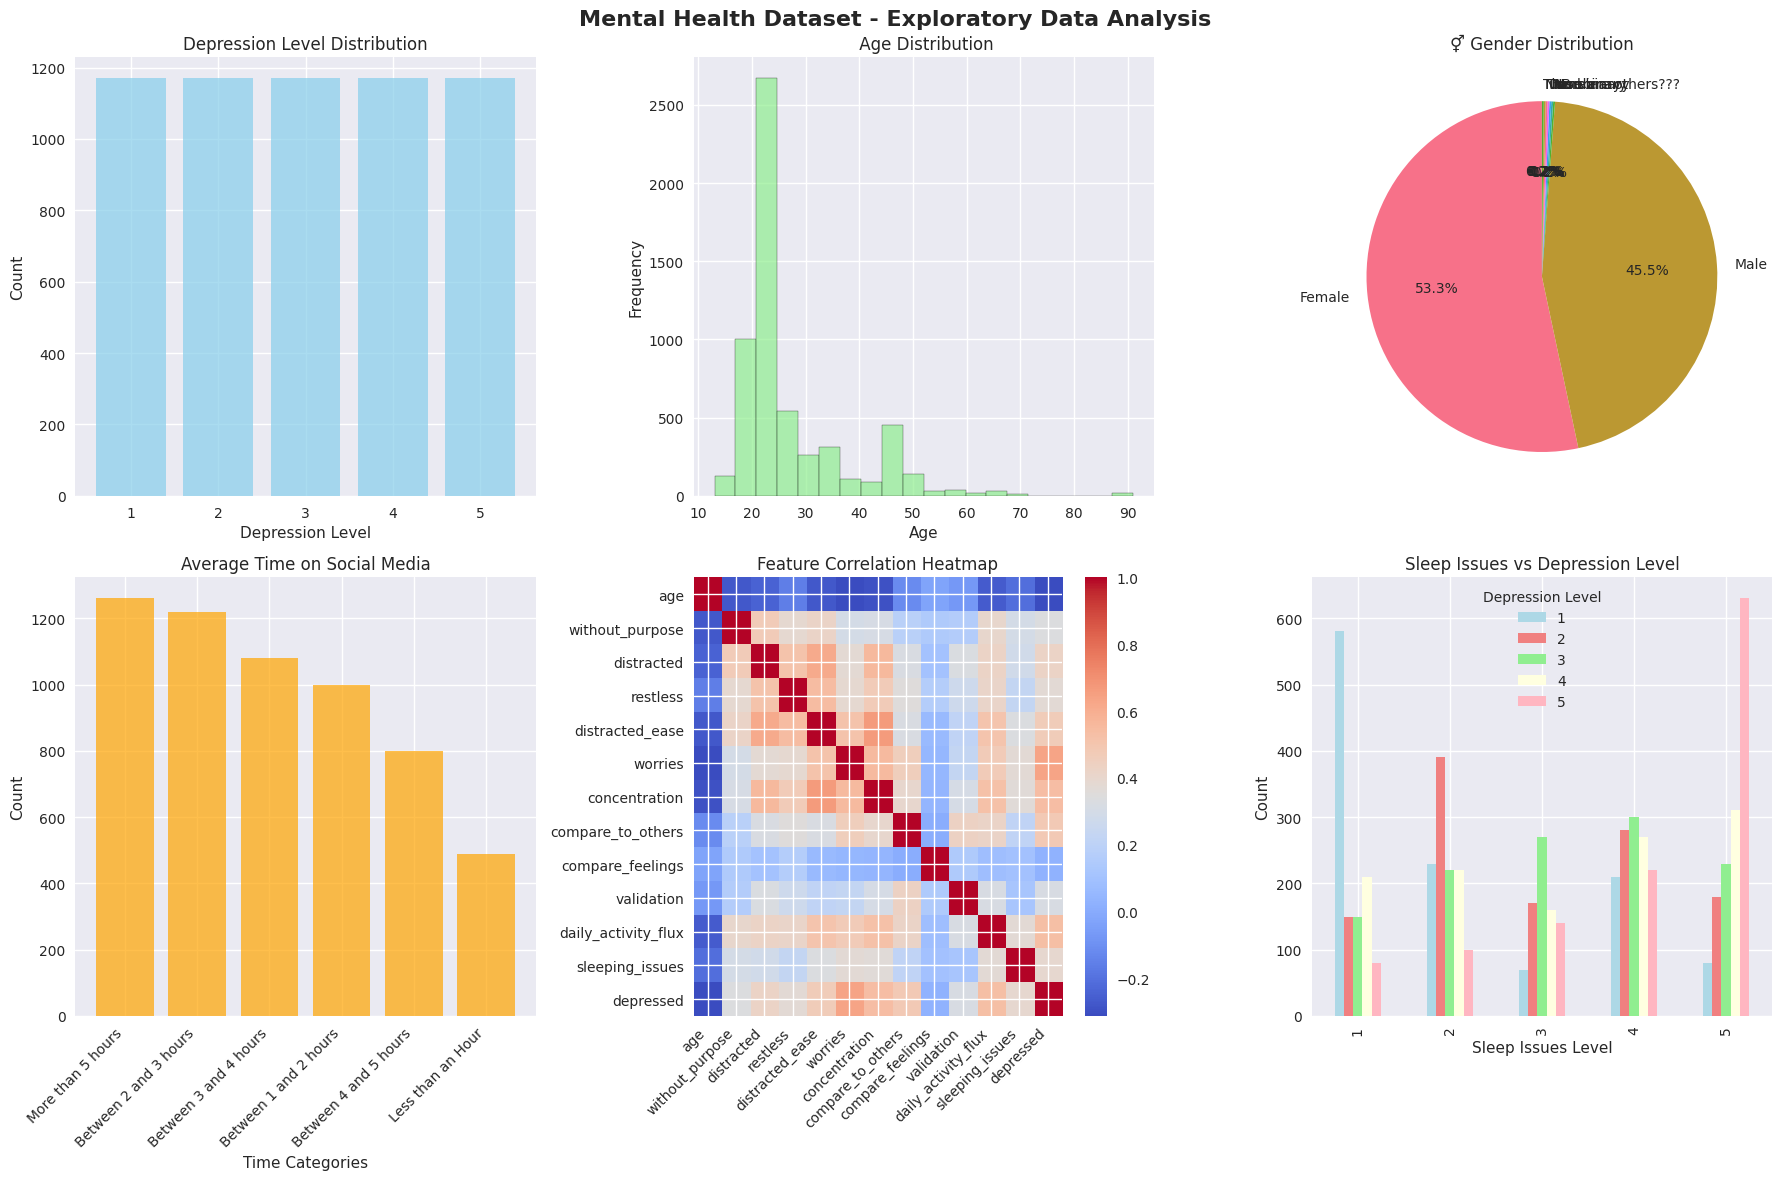

In [7]:

#@title  5: Exploratory Data Analysis and Visualization
"""
Perform comprehensive exploratory data analysis with visualizations.
"""
def create_eda_visualizations(df):
    """
    Create comprehensive exploratory data analysis visualizations.

    Args:
        df (pd.DataFrame): Preprocessed dataset
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Mental Health Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    # Target variable distribution
    target_counts = df['depressed'].value_counts().sort_index()
    axes[0, 0].bar(target_counts.index, target_counts.values, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Depression Level Distribution')
    axes[0, 0].set_xlabel('Depression Level')
    axes[0, 0].set_ylabel('Count')

    # Age distribution
    axes[0, 1].hist(df['age'], bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title(' Age Distribution')
    axes[0, 1].set_xlabel('Age')
    axes[0, 1].set_ylabel('Frequency')

    # Gender distribution
    gender_counts = df['gender'].value_counts()
    axes[0, 2].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 2].set_title('⚥ Gender Distribution')

    # Social media usage time
    time_counts = df['avg_time_per_day'].value_counts()
    axes[1, 0].bar(range(len(time_counts)), time_counts.values, color='orange', alpha=0.7)
    axes[1, 0].set_title('Average Time on Social Media')
    axes[1, 0].set_xlabel('Time Categories')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_xticks(range(len(time_counts)))
    axes[1, 0].set_xticklabels(time_counts.index, rotation=45, ha='right')

    # Correlation heatmap for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    im = axes[1, 1].imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    axes[1, 1].set_title('Feature Correlation Heatmap')
    axes[1, 1].set_xticks(range(len(numeric_cols)))
    axes[1, 1].set_yticks(range(len(numeric_cols)))
    axes[1, 1].set_xticklabels(numeric_cols, rotation=45, ha='right')
    axes[1, 1].set_yticklabels(numeric_cols)
    plt.colorbar(im, ax=axes[1, 1])

    # Sleep issues vs Depression
    sleep_depression = pd.crosstab(df['sleeping_issues'], df['depressed'])
    sleep_depression.plot(kind='bar', ax=axes[1, 2], color=['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink'])
    axes[1, 2].set_title('Sleep Issues vs Depression Level')
    axes[1, 2].set_xlabel('Sleep Issues Level')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].legend(title='Depression Level')

    plt.tight_layout()
    plt.show()


# Create EDA visualizations
create_eda_visualizations(df_processed)

Creating graph edges based on cosine similarity...
Similarity threshold: 0.334
Graph created successfully!
Nodes: 5850
Edges: 5127250
Features: 20
Classes: 5


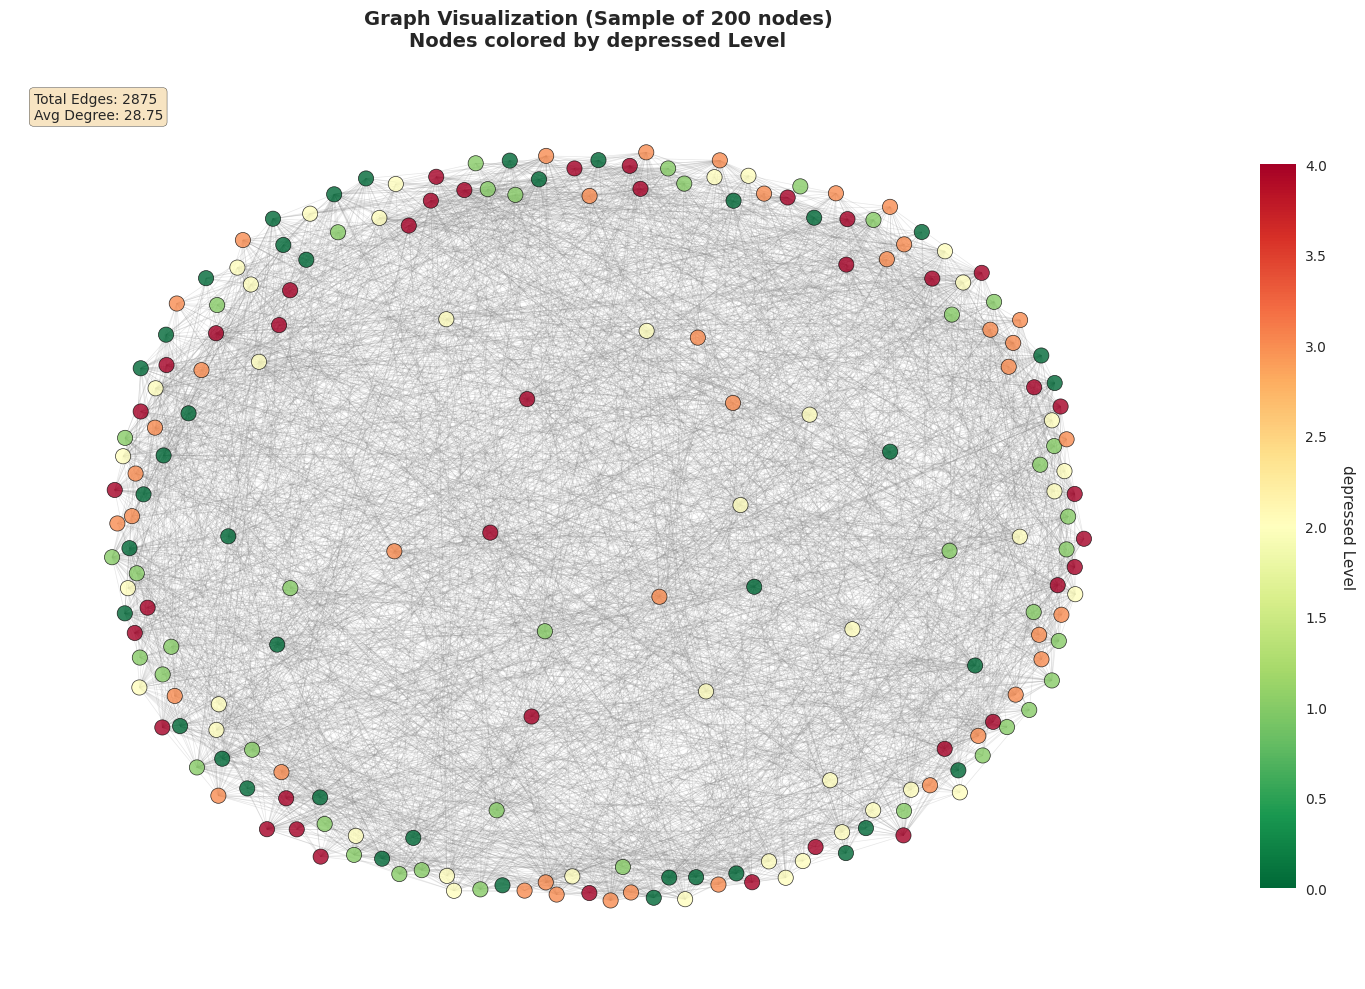

In [8]:

#@title  6: Graph Construction and Visualization

def create_graph_data(df, target_col='depressed', similarity_threshold_percentile=85):
    """
    Create PyTorch Geometric data object from the preprocessed dataset.

    Args:
        df (pd.DataFrame): Preprocessed dataset
        target_col (str): Name of the target column
        similarity_threshold_percentile (float): Percentile for similarity threshold

    Returns:
        torch_geometric.data.Data: Graph data object
        dict: Additional information about the graph
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")

    df_graph = df.copy()

    # Encode categorical columns (excluding target)
    cat_cols = df_graph.select_dtypes(include='object').columns
    cat_cols = [col for col in cat_cols if col != target_col]  # Exclude target if it's categorical
    label_encoders = {}

    for col in cat_cols:
        le = LabelEncoder()
        df_graph[col] = le.fit_transform(df_graph[col])
        label_encoders[col] = le

    # Prepare features (exclude target variable)
    features = df_graph.drop(columns=[target_col])

    # Normalize features
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(features)
    x = torch.tensor(x_normalized, dtype=torch.float)

    # Prepare labels - handle both 0-indexed and 1-indexed labels
    target_values = df_graph[target_col].values
    unique_values = np.unique(target_values)

    if min(unique_values) == 0:
        # Already 0-indexed
        y = torch.tensor(target_values, dtype=torch.long)
    else:
        # Convert to 0-indexed
        y = torch.tensor(target_values - min(unique_values), dtype=torch.long)

    print(f"Creating graph edges based on cosine similarity...")

    # For large datasets, consider using sparse similarity computation
    if len(df_graph) > 5000:
        print("Warning: Large dataset detected. Consider using sparse similarity computation.")

    sim_matrix = cosine_similarity(x_normalized)

    # Use adaptive threshold based on data distribution
    threshold = np.percentile(sim_matrix.flatten(), similarity_threshold_percentile)
    print(f"Similarity threshold: {threshold:.3f}")

    # More efficient edge creation using vectorized operations
    upper_tri_indices = np.triu_indices(sim_matrix.shape[0], k=1)
    similarities = sim_matrix[upper_tri_indices]

    # Find edges above threshold
    edge_mask = similarities > threshold
    source_nodes = upper_tri_indices[0][edge_mask]
    target_nodes = upper_tri_indices[1][edge_mask]
    edge_similarities = similarities[edge_mask]

    if len(source_nodes) == 0:
        print("No edges found with current threshold. Using lower threshold...")
        threshold = np.percentile(sim_matrix.flatten(), max(70, similarity_threshold_percentile - 15))
        edge_mask = similarities > threshold
        source_nodes = upper_tri_indices[0][edge_mask]
        target_nodes = upper_tri_indices[1][edge_mask]
        edge_similarities = similarities[edge_mask]

    # Create undirected edges
    edge_list = np.concatenate([
        np.vstack([source_nodes, target_nodes]),
        np.vstack([target_nodes, source_nodes])
    ], axis=1)

    edge_weights = np.concatenate([edge_similarities, edge_similarities])

    edge_index = torch.tensor(edge_list, dtype=torch.long)
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)

    # Create train/validation/test masks with stratified sampling
    num_nodes = x.shape[0]

    # Stratify by target labels to ensure balanced splits
    unique_labels = torch.unique(y)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    for label in unique_labels:
        label_indices = torch.where(y == label)[0]
        label_indices = label_indices[torch.randperm(len(label_indices))]

        n_label = len(label_indices)
        train_size = int(0.6 * n_label)
        val_size = int(0.2 * n_label)

        train_mask[label_indices[:train_size]] = True
        val_mask[label_indices[train_size:train_size + val_size]] = True
        test_mask[label_indices[train_size + val_size:]] = True

    # Create data object
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_weights,
        y=y,
        train_mask=train_mask,
        val_mask=val_mask,
        test_mask=test_mask
    )

    graph_info = {
        'num_nodes': num_nodes,
        'num_edges': edge_index.shape[1],
        'num_features': x.shape[1],
        'num_classes': len(unique_labels),
        'label_encoders': label_encoders,
        'scaler': scaler,
        'threshold': threshold,
        'target_col': target_col
    }

    print(f"Graph created successfully!")
    print(f"Nodes: {graph_info['num_nodes']}")
    print(f"Edges: {graph_info['num_edges']}")
    print(f"Features: {graph_info['num_features']}")
    print(f"Classes: {graph_info['num_classes']}")

    return data, graph_info

def visualize_graph(data, graph_info, sample_size=200, figsize=(15, 10)):
    """
    Visualize the graph structure with node coloring based on target labels.

    Args:
        data: PyTorch Geometric data object
        graph_info: Dictionary with graph information
        sample_size: Number of nodes to sample for visualization
        figsize: Figure size tuple
    """

    # Sample nodes for visualization if graph is too large
    if data.num_nodes > sample_size:
        # Stratified sampling to maintain label distribution
        unique_labels = torch.unique(data.y)
        sample_indices = []

        samples_per_label = sample_size // len(unique_labels)

        for label in unique_labels:
            label_indices = torch.where(data.y == label)[0]
            if len(label_indices) > samples_per_label:
                sampled = label_indices[torch.randperm(len(label_indices))[:samples_per_label]]
            else:
                sampled = label_indices
            sample_indices.append(sampled)

        sample_indices = torch.cat(sample_indices)

        # Create node mapping for reindexing
        node_mapping = {idx.item(): i for i, idx in enumerate(sample_indices)}

        # Filter edges that connect sampled nodes
        edge_mask = torch.isin(data.edge_index[0], sample_indices) & torch.isin(data.edge_index[1], sample_indices)
        sample_edges = data.edge_index[:, edge_mask]

        # Remap edge indices
        sample_edges_remapped = torch.zeros_like(sample_edges)
        for i in range(sample_edges.shape[1]):
            sample_edges_remapped[0, i] = node_mapping[sample_edges[0, i].item()]
            sample_edges_remapped[1, i] = node_mapping[sample_edges[1, i].item()]

        sample_data = Data(
            x=data.x[sample_indices],
            edge_index=sample_edges_remapped,
            y=data.y[sample_indices]
        )
        num_sampled = len(sample_indices)
    else:
        sample_data = data
        num_sampled = data.num_nodes

    # Convert to NetworkX
    G = to_networkx(sample_data, to_undirected=True)

    # Create layout with better parameters for readability
    pos = nx.spring_layout(G, k=3, iterations=50, seed=42)  # Added seed for reproducibility

    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)

    # Color nodes by target labels
    target_values = sample_data.y.numpy()

    # Use a better colormap and normalize
    if len(np.unique(target_values)) > 1:
        colors = plt.cm.RdYlGn_r(target_values / max(target_values))
    else:
        colors = 'skyblue'  # Single color if all labels are the same

    # Draw the graph with better styling
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, node_size=120,
                          alpha=0.8, linewidths=0.5, edgecolors='black')
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.2, width=0.5, edge_color='gray')

    # Add colorbar if there are multiple classes
    if len(np.unique(target_values)) > 1:
        sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r,
                                  norm=plt.Normalize(vmin=min(target_values),
                                                   vmax=max(target_values)))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
        cbar.set_label(f'{graph_info.get("target_col", "Target")} Level',
                      rotation=270, labelpad=20)

    # Improved title and formatting
    title = f'Graph Visualization (Sample of {num_sampled} nodes)\n'
    title += f'Nodes colored by {graph_info.get("target_col", "Target")} Level'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')

    # Add graph statistics as text
    stats_text = f'Total Edges: {sample_data.edge_index.shape[1]//2}\n'
    stats_text += f'Avg Degree: {sample_data.edge_index.shape[1]/sample_data.num_nodes:.2f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Example usage (assuming df_processed exists):
data, graph_info = create_graph_data(df_processed, target_col='depressed')
visualize_graph(data, graph_info)

In [9]:
data

Data(x=[5850, 20], edge_index=[2, 5127250], edge_attr=[5127250], y=[5850], train_mask=[5850], val_mask=[5850], test_mask=[5850])

# Modelling

In [10]:

#@title  7: GNN Model Definitions
"""
Define different Graph Neural Network architectures for comparison.
"""
class GCN(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) implementation.

    Args:
        in_channels (int): Number of input features
        hidden_channels (int): Number of hidden units
        out_channels (int): Number of output classes
        num_layers (int): Number of GCN layers
        dropout (float): Dropout probability
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, edge_index)
        return x

class GraphSAGE(torch.nn.Module):
    """
    GraphSAGE implementation for inductive representation learning.

    Args:
        in_channels (int): Number of input features
        hidden_channels (int): Number of hidden units
        out_channels (int): Number of output classes
        num_layers (int): Number of SAGE layers
        dropout (float): Dropout probability
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, edge_index)
        return x

class GAT(torch.nn.Module):
    """
    Graph Attention Network (GAT) implementation.

    Args:
        in_channels (int): Number of input features
        hidden_channels (int): Number of hidden units
        out_channels (int): Number of output classes
        heads (int): Number of attention heads
        num_layers (int): Number of GAT layers
        dropout (float): Dropout probability
    """
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, num_layers=2, dropout=0.5):
        super(GAT, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))

        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))

        self.convs.append(GATConv(hidden_channels * heads, out_channels, heads=1, dropout=dropout))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.convs[:-1]):
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = conv(x, edge_index)
            x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

print("📋 Available models: GCN, GraphSAGE, GAT")


📋 Available models: GCN, GraphSAGE, GAT


In [11]:

#@title  8: Training and Evaluation Framework
"""
Comprehensive training and evaluation framework for GNN models.
"""
class GNNTrainer:
    """
    Trainer class for Graph Neural Networks with comprehensive evaluation.
    """
    def __init__(self, model, data, device='cpu'):
        self.model = model.to(device)
        self.data = data.to(device)
        self.device = device
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def train_epoch(self, optimizer, criterion):
        """Train for one epoch."""
        self.model.train()
        optimizer.zero_grad()

        out = self.model(self.data)
        loss = criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])

        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        pred = out[self.data.train_mask].argmax(dim=1)
        train_acc = (pred == self.data.y[self.data.train_mask]).float().mean()

        return loss.item(), train_acc.item()

    def evaluate(self, criterion, mask_name='val'):
        """Evaluate the model on validation or test set."""
        self.model.eval()
        with torch.no_grad():
            out = self.model(self.data)

            if mask_name == 'val':
                mask = self.data.val_mask
            else:
                mask = self.data.test_mask

            loss = criterion(out[mask], self.data.y[mask])
            pred = out[mask].argmax(dim=1)
            acc = (pred == self.data.y[mask]).float().mean()

        return loss.item(), acc.item(), pred.cpu(), self.data.y[mask].cpu()

    def train(self, epochs=200, lr=0.01, weight_decay=5e-4, patience=20, verbose=True):
        """
        Train the model with early stopping.

        Args:
            epochs (int): Maximum number of epochs
            lr (float): Learning rate
            weight_decay (float): Weight decay for regularization
            patience (int): Early stopping patience
            verbose (bool): Print training progress
        """
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.CrossEntropyLoss()

        best_val_acc = 0
        patience_counter = 0

        if verbose:
            print(f"Training {self.model.__class__.__name__} model...")
            print(f"Epochs: {epochs}, LR: {lr}, Weight Decay: {weight_decay}")

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(optimizer, criterion)
            val_loss, val_acc, _, _ = self.evaluate(criterion, 'val')

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Save best model state
                self.best_model_state = self.model.state_dict().copy()
            else:
                patience_counter += 1

            if patience_counter >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break

            if verbose and (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f}, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}")

        # Load best model
        self.model.load_state_dict(self.best_model_state)

        if verbose:
            print(f"Training completed! Best validation accuracy: {best_val_acc:.3f}")

        return self.history

    def get_embeddings(self):
        """Get node embeddings from the trained model."""
        self.model.eval()
        with torch.no_grad():
            if hasattr(self.model, 'convs'):
                x, edge_index = self.data.x, self.data.edge_index

                # Forward pass through all layers except the last one
                for conv in self.model.convs[:-1]:
                    x = conv(x, edge_index)
                    x = F.relu(x)

                return x.cpu().numpy()
            else:
                return self.model(self.data).cpu().numpy()

def evaluate_model_comprehensive(trainer, model_name):
    """
    Perform comprehensive evaluation of a trained model.

    Args:
        trainer: Trained GNNTrainer instance
        model_name: Name of the model for reporting

    Returns:
        dict: Comprehensive evaluation results
    """
    criterion = torch.nn.CrossEntropyLoss()

    # Test set evaluation
    test_loss, test_acc, test_pred, test_true = trainer.evaluate(criterion, 'test')

    # Classification report
    class_report = classification_report(test_true.numpy(), test_pred.numpy(),
                                       target_names=[f'Class_{i}' for i in range(len(torch.unique(test_true)))],
                                       output_dict=True)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_true.numpy(), test_pred.numpy())

    results = {
        'model_name': model_name,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'predictions': test_pred.numpy(),
        'true_labels': test_true.numpy()
    }

    print(f"{model_name} Test Results:")
    print(f"Test Accuracy: {test_acc:.3f}")
    print(f"Test Loss: {test_loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_true.numpy(), test_pred.numpy(),
                              target_names=[f'Class_{i}' for i in range(len(torch.unique(test_true)))]))

    return results


In [12]:

#@title  9: Model Comparison Experiment
"""
Train and compare different GNN architectures.
"""
def run_model_comparison(data, graph_info):
    """
    Run comprehensive comparison of different GNN models.

    Args:
        data: PyTorch Geometric data object
        graph_info: Dictionary with graph information

    Returns:
        dict: Results from all models
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Model configurations
    models_config = {
        'GCN': {
            'class': GCN,
            'params': {
                'in_channels': graph_info['num_features'],
                'hidden_channels': 64,
                'out_channels': graph_info['num_classes'],
                'num_layers': 2,
                'dropout': 0.5
            }
        },
        'GraphSAGE': {
            'class': GraphSAGE,
            'params': {
                'in_channels': graph_info['num_features'],
                'hidden_channels': 64,
                'out_channels': graph_info['num_classes'],
                'num_layers': 2,
                'dropout': 0.5
            }
        },
        'GAT': {
            'class': GAT,
            'params': {
                'in_channels': graph_info['num_features'],
                'hidden_channels': 32,  # Smaller due to multi-head attention
                'out_channels': graph_info['num_classes'],
                'heads': 4,
                'num_layers': 2,
                'dropout': 0.5
            }
        }
    }

    results = {}
    trainers = {}

    print("Starting model comparison experiment...")
    print("="*60)

    for model_name, config in models_config.items():
        print(f"\n Training {model_name}...")

        # Initialize model
        model = config['class'](**config['params'])

        # Initialize trainer
        trainer = GNNTrainer(model, data, device)

        # Train model
        history = trainer.train(epochs=300, lr=0.01, weight_decay=5e-4, patience=50)

        # Evaluate model
        model_results = evaluate_model_comprehensive(trainer, model_name)

        # Store results
        results[model_name] = model_results
        results[model_name]['history'] = history
        trainers[model_name] = trainer

        print("-"*40)

    print("\n Model comparison completed!")
    return results, trainers

# Run the model comparison
model_results, model_trainers = run_model_comparison(data, graph_info)

Using device: cuda
Starting model comparison experiment...

 Training GCN...
Training GCN model...
Epochs: 300, LR: 0.01, Weight Decay: 0.0005
Epoch  20: Train Loss: 1.3224, Train Acc: 0.407, Val Loss: 1.3443, Val Acc: 0.388
Epoch  40: Train Loss: 1.2870, Train Acc: 0.438, Val Loss: 1.2996, Val Acc: 0.436
Epoch  60: Train Loss: 1.2576, Train Acc: 0.459, Val Loss: 1.2709, Val Acc: 0.426
Epoch  80: Train Loss: 1.2320, Train Acc: 0.471, Val Loss: 1.2449, Val Acc: 0.433
Epoch 100: Train Loss: 1.2148, Train Acc: 0.479, Val Loss: 1.2256, Val Acc: 0.463
Epoch 120: Train Loss: 1.2000, Train Acc: 0.483, Val Loss: 1.2134, Val Acc: 0.468
Epoch 140: Train Loss: 1.1894, Train Acc: 0.496, Val Loss: 1.2053, Val Acc: 0.469
Epoch 160: Train Loss: 1.1825, Train Acc: 0.485, Val Loss: 1.1943, Val Acc: 0.457
Epoch 180: Train Loss: 1.1782, Train Acc: 0.498, Val Loss: 1.1890, Val Acc: 0.463
Epoch 200: Train Loss: 1.1653, Train Acc: 0.478, Val Loss: 1.1829, Val Acc: 0.458
Epoch 220: Train Loss: 1.1657, Train 

In [13]:

#@title  10: Visualization Functions
"""
Create comprehensive visualizations for model performance and analysis.
"""
def plot_training_curves(results):
    """
    Plot training and validation curves for all models.

    Args:
        results: Dictionary containing model results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Curves Comparison', fontsize=16, fontweight='bold')

    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Training Loss
    for i, (model_name, result) in enumerate(results.items()):
        history = result['history']
        axes[0, 0].plot(history['train_loss'], label=f'{model_name}', color=colors[i], linewidth=2)

    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Validation Loss
    for i, (model_name, result) in enumerate(results.items()):
        history = result['history']
        axes[0, 1].plot(history['val_loss'], label=f'{model_name}', color=colors[i], linewidth=2)

    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Training Accuracy
    for i, (model_name, result) in enumerate(results.items()):
        history = result['history']
        axes[1, 0].plot(history['train_acc'], label=f'{model_name}', color=colors[i], linewidth=2)

    axes[1, 0].set_title('Training Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Validation Accuracy
    for i, (model_name, result) in enumerate(results.items()):
        history = result['history']
        axes[1, 1].plot(history['val_acc'], label=f'{model_name}', color=colors[i], linewidth=2)

    axes[1, 1].set_title('Validation Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results):
    """
    Plot confusion matrices for all models.

    Args:
        results: Dictionary containing model results
    """
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))

    if n_models == 1:
        axes = [axes]

    fig.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')

    for i, (model_name, result) in enumerate(results.items()):
        conf_matrix = result['confusion_matrix']

        im = axes[i].imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        axes[i].figure.colorbar(im, ax=axes[i])

        # Add text annotations
        thresh = conf_matrix.max() / 2.
        for row in range(conf_matrix.shape[0]):
            for col in range(conf_matrix.shape[1]):
                axes[i].text(col, row, format(conf_matrix[row, col], 'd'),
                           ha="center", va="center",
                           color="white" if conf_matrix[row, col] > thresh else "black")

        axes[i].set_title(f'{model_name}\nAccuracy: {result["test_accuracy"]:.3f}')
        axes[i].set_ylabel('True Label')
        axes[i].set_xlabel('Predicted Label')

        # Set tick labels
        n_classes = conf_matrix.shape[0]
        axes[i].set_xticks(range(n_classes))
        axes[i].set_yticks(range(n_classes))
        axes[i].set_xticklabels([f'Class {i}' for i in range(n_classes)])
        axes[i].set_yticklabels([f'Class {i}' for i in range(n_classes)])

    plt.tight_layout()
    plt.show()



def plot_embeddings_visualization(trainers, data, method='tsne'):
    """
    Visualize node embeddings using dimensionality reduction.

    Args:
        trainers: Dictionary of trained model trainers
        data: PyTorch Geometric data object
        method: Dimensionality reduction method ('tsne', 'pca', or 'umap')
    """
    n_models = len(trainers)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    if n_models == 1:
        axes = [axes]

    method_name = method.upper()
    fig.suptitle(f'Node Embeddings Visualization ({method_name})', fontsize=16, fontweight='bold')

    for i, (model_name, trainer) in enumerate(trainers.items()):
        # Get embeddings
        embeddings = trainer.get_embeddings()
        labels = data.y.cpu().numpy()

        # Apply dimensionality reduction
        if method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        elif method == 'pca':
            reducer = PCA(n_components=2, random_state=42)
        elif method == 'umap' and UMAP_AVAILABLE:
            reducer = umap.UMAP(n_components=2, random_state=42)
        else:
            print(f"{method} not available, using PCA instead")
            reducer = PCA(n_components=2, random_components=42)

        embeddings_2d = reducer.fit_transform(embeddings)

        # Create scatter plot
        scatter = axes[i].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                                c=labels, cmap='viridis', alpha=0.7, s=50)

        axes[i].set_title(f'{model_name}')
        axes[i].set_xlabel(f'{method_name} Component 1')
        axes[i].set_ylabel(f'{method_name} Component 2')

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[i])
        cbar.set_label('Depression Level')

    plt.tight_layout()
    plt.show()

def plot_model_comparison_bar(results):
    """
    Create bar plot comparing model performance metrics.

    Args:
        results: Dictionary containing model results
    """
    # FIX: Renamed 'models' to 'model_names' to avoid potential variable name collisions.

    print(results.keys())
    results_keys = results.keys()
    model_names = __builtins__.list(results_keys)
    test_accuracies = [results[name]['test_accuracy'] for name in model_names]

    # Extract precision, recall, F1-score (macro avg)
    precisions = [results[name]['classification_report']['macro avg']['precision'] for name in model_names]
    recalls = [results[name]['classification_report']['macro avg']['recall'] for name in model_names]
    f1_scores = [results[name]['classification_report']['macro avg']['f1-score'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 8))

    bars1 = ax.bar(x - width*1.5, test_accuracies, width, label='Test Accuracy', alpha=0.8)
    bars2 = ax.bar(x - width/2, precisions, width, label='Precision (Macro)', alpha=0.8)
    bars3 = ax.bar(x + width/2, recalls, width, label='Recall (Macro)', alpha=0.8)
    bars4 = ax.bar(x + width*1.5, f1_scores, width, label='F1-Score (Macro)', alpha=0.8)

    ax.set_ylabel('Score')
    ax.set_title(' Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names) # Use the new variable name
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontsize=9)

    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    add_value_labels(bars4)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

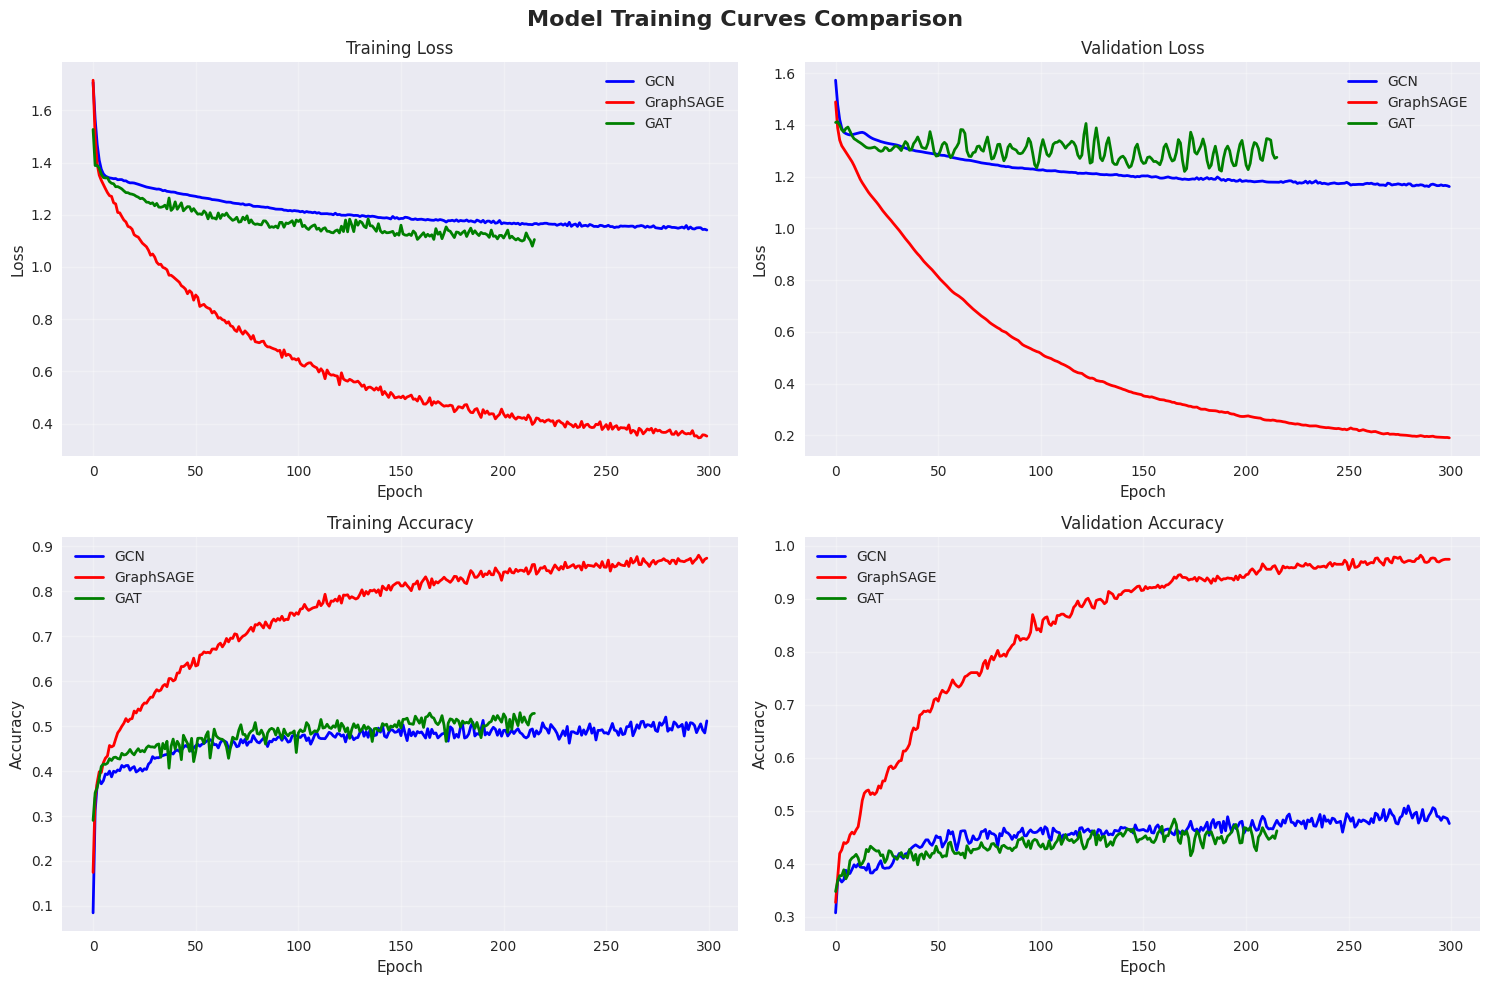

In [14]:
# Training curves
plot_training_curves(model_results)

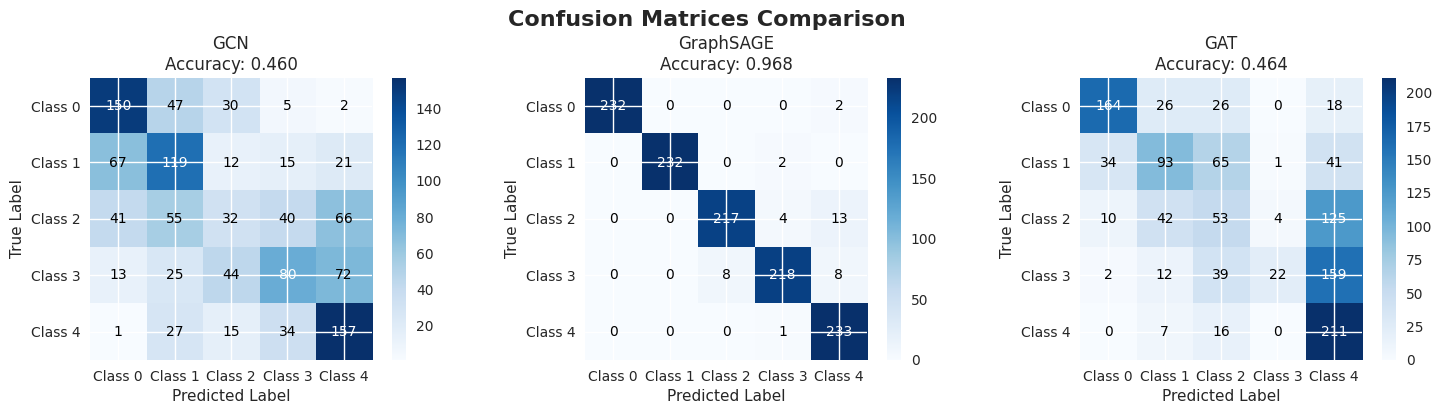

In [15]:
# Confusion matrices
plot_confusion_matrices(model_results)

dict_keys(['GCN', 'GraphSAGE', 'GAT'])


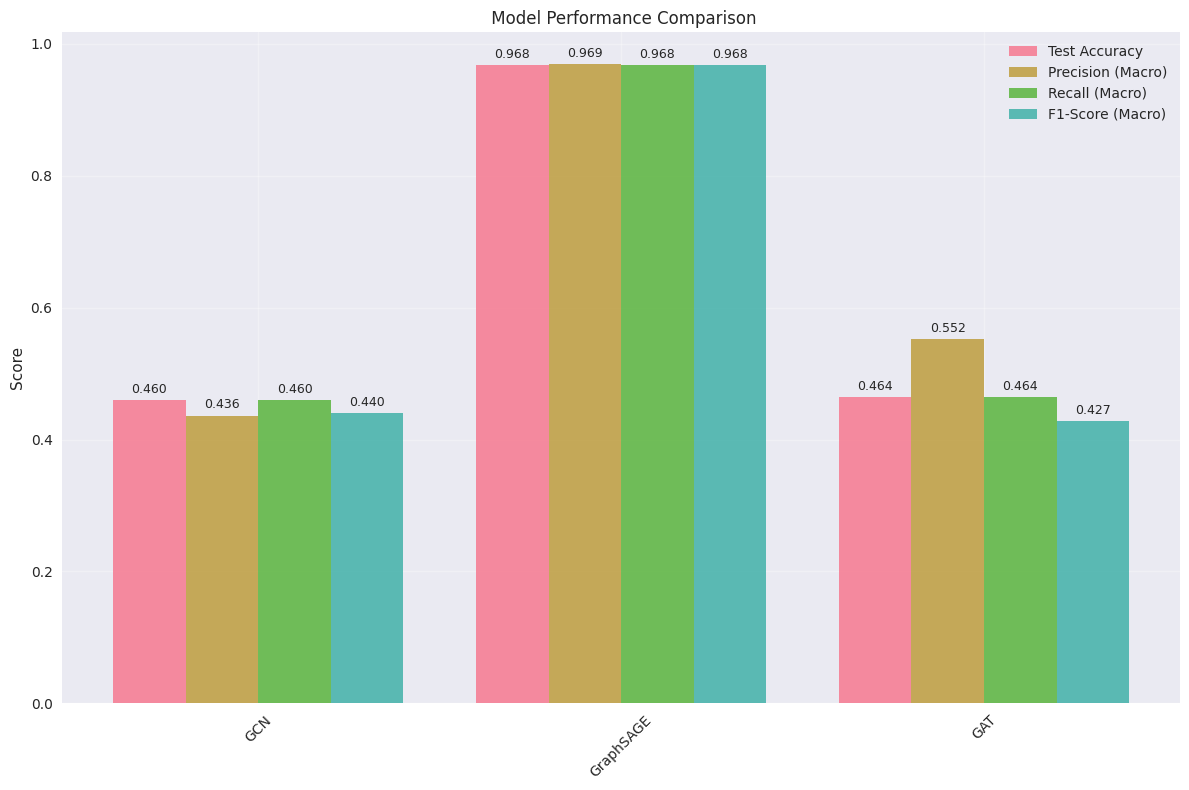

In [16]:
# Model comparison bar chart
plot_model_comparison_bar(model_results)

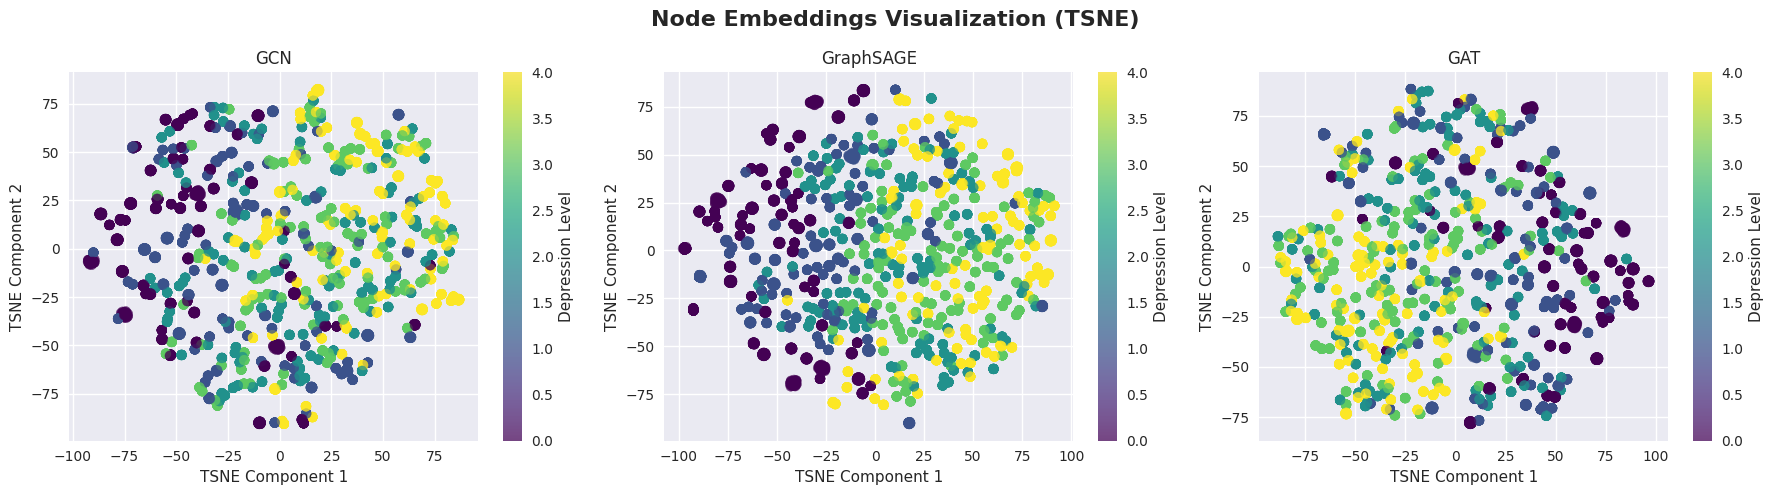

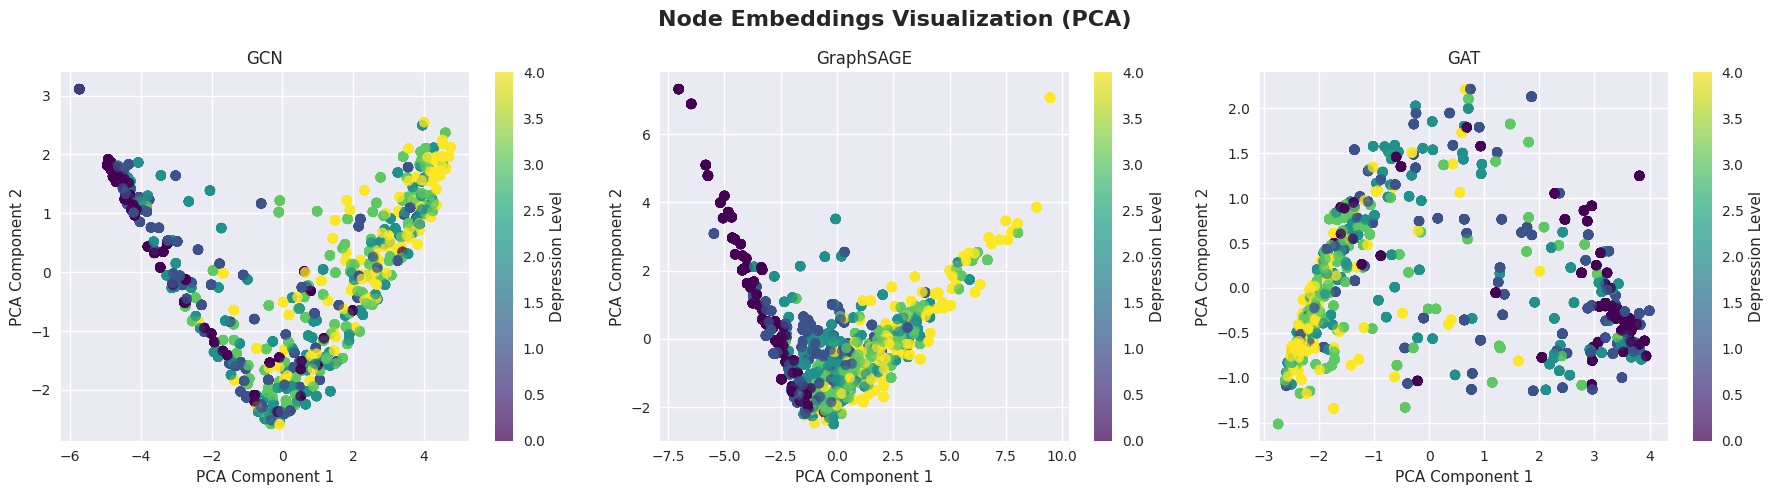

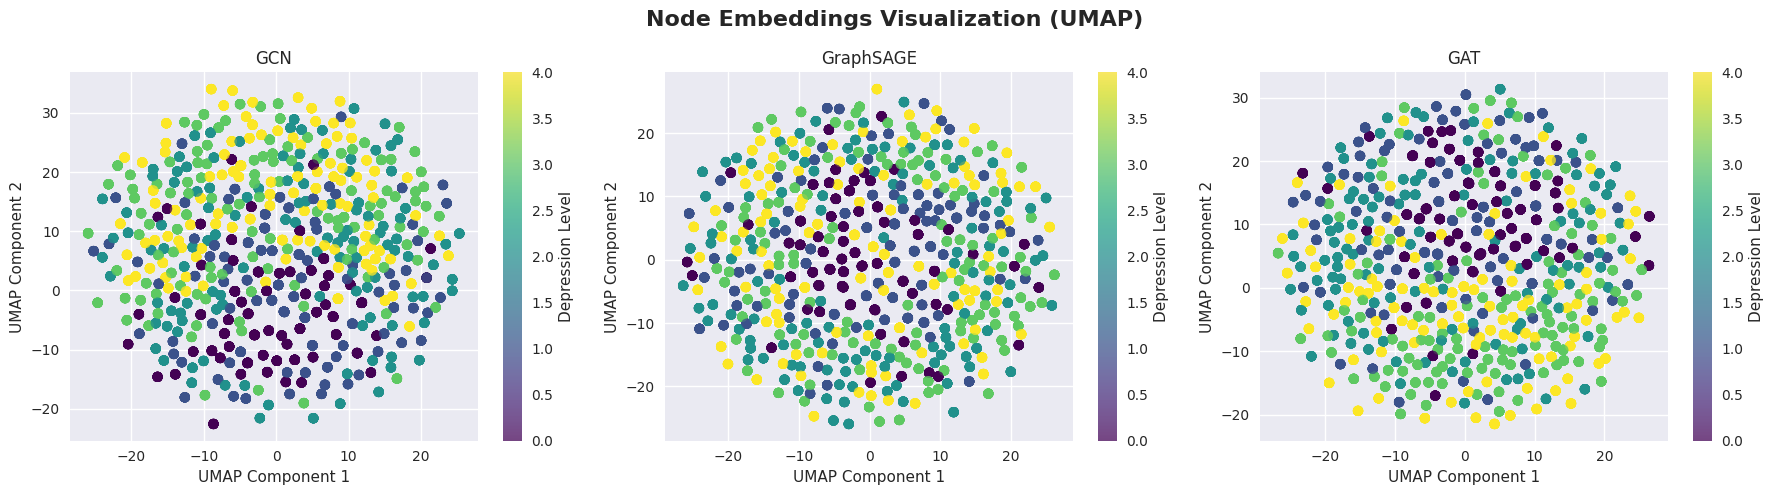

In [24]:
# Embeddings visualization
plot_embeddings_visualization(model_trainers, data, 'tsne')
plot_embeddings_visualization(model_trainers, data, 'pca')

if UMAP_AVAILABLE:
    plot_embeddings_visualization(model_trainers, data, 'umap')


Best Performing Model: GraphSAGE
Best Test Accuracy: 0.968

Performance Analysis:
  GCN          | Accuracy: 0.460 | F1-Macro: 0.440 | BASELINE
  GraphSAGE    | Accuracy: 0.968 | F1-Macro: 0.968 | BEST
  GAT          | Accuracy: 0.464 | F1-Macro: 0.427 | BASELINE

Feature Importance Analysis
Using GraphSAGE for feature importance analysis...
Top 10 Most Important Features:
   1. Feature_13      | Importance: 0.0935
   2. Feature_15      | Importance: 0.0831
   3. Feature_17      | Importance: 0.0707
   4. Feature_14      | Importance: 0.0640
   5. Feature_19      | Importance: 0.0568
   6. Feature_18      | Importance: 0.0543
   7. Feature_10      | Importance: 0.0512
   8. Feature_3       | Importance: 0.0511
   9. Feature_7       | Importance: 0.0509
  10. Feature_1       | Importance: 0.0498


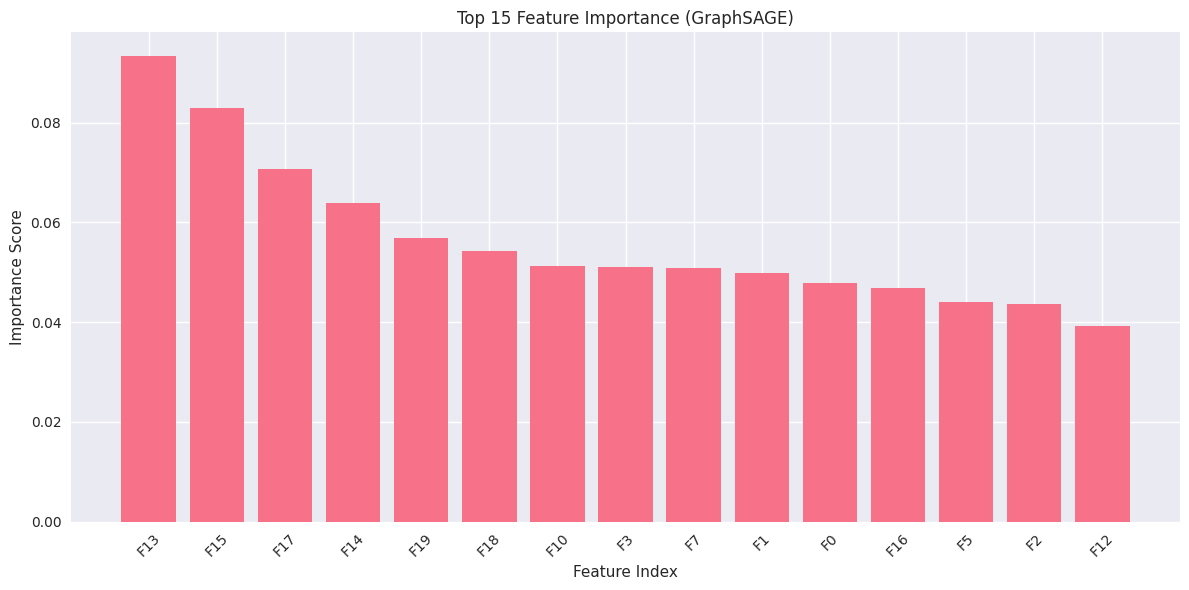

In [21]:
#@title 11: Advanced Analysis and Insights
"""
Perform advanced analysis and generate insights from the results.
"""
def generate_model_recommendations(results):
    """
    Generate recommendations based on model performance analysis.

    Args:
        results: Dictionary containing model results
    """

    # Find best performing model
    best_model = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
    best_accuracy = results[best_model]['test_accuracy']

    print(f"Best Performing Model: {best_model}")
    print(f"Best Test Accuracy: {best_accuracy:.3f}")

    # Performance analysis
    print(f"\nPerformance Analysis:")
    for model_name, result in results.items():
        accuracy = result['test_accuracy']
        f1_macro = result['classification_report']['macro avg']['f1-score']

        if model_name == best_model:
            status = "BEST"
        elif accuracy >= best_accuracy - 0.02:
            status = "COMPETITIVE"
        else:
            status = "BASELINE"

        print(f"  {model_name:12} | Accuracy: {accuracy:.3f} | F1-Macro: {f1_macro:.3f} | {status}")

    # Generate specific recommendations
    recommendations = {
        'best_model': best_model,
        'best_accuracy': best_accuracy,
        'insights': []
    }



    return recommendations

def analyze_feature_importance_proxy(trainers, data, graph_info):
    """
    Analyze feature importance using gradient-based attribution as a proxy.

    Args:
        trainers: Dictionary of trained model trainers
        data: PyTorch Geometric data object
        graph_info: Dictionary with graph information
    """
    print("\nFeature Importance Analysis")
    print("="*50)

    # Use the best performing model for feature analysis
    best_model_name = max(trainers.keys(), key=lambda x: model_results[x]['test_accuracy'])
    trainer = trainers[best_model_name]
    device = trainer.device # Get the device the trainer is using

    print(f"Using {best_model_name} for feature importance analysis...")

    # Move data to the same device as the model
    data = data.to(device)

    # Enable gradients for input
    data.x.requires_grad_(True)
    trainer.model.eval()

    # Forward pass
    output = trainer.model(data)

    # Calculate gradients for each class
    n_features = data.x.shape[1]
    feature_importance = torch.zeros(n_features, device=device) # Initialize on the correct device

    for class_idx in range(output.shape[1]):
        # Backward pass for each class
        if data.x.grad is not None:
            data.x.grad.zero_()

        class_output = output[:, class_idx].sum()
        class_output.backward(retain_graph=True)

        # Accumulate absolute gradients
        feature_importance += torch.abs(data.x.grad).mean(dim=0)

    # Normalize importance scores
    feature_importance = feature_importance / output.shape[1]
    feature_importance = feature_importance / feature_importance.sum()

    # Get feature names (simplified)
    feature_names = [f'Feature_{i}' for i in range(n_features)]

    # Sort by importance
    importance_indices = torch.argsort(feature_importance, descending=True)

    print(f"Top 10 Most Important Features:")
    for i in range(min(10, len(importance_indices))):
        idx = importance_indices[i]
        print(f"  {i+1:2d}. {feature_names[idx]:15} | Importance: {feature_importance[idx]:.4f}")

    # Visualize feature importance
    plt.figure(figsize=(12, 6))
    top_features = importance_indices[:15].cpu() # Move to CPU for plotting
    plt.bar(range(len(top_features)), feature_importance[top_features].cpu().detach().numpy()) # Move to CPU for plotting
    plt.title(f'Top 15 Feature Importance ({best_model_name})')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance Score')
    plt.xticks(range(len(top_features)), [f'F{idx}' for idx in top_features], rotation=45)
    plt.tight_layout()
    plt.show()

    data.x.requires_grad_(False)  # Reset gradient requirement



# Run advanced analysis
recommendations = generate_model_recommendations(model_results)
analyze_feature_importance_proxy(model_trainers, data, graph_info)

In [22]:
#@title 12: Interactive Visualization (Optional)
"""
Create interactive visualizations using Plotly for better exploration.
"""
def create_interactive_embeddings_plot(trainers, data):
    """
    Create interactive 3D embeddings plot using Plotly.

    Args:
        trainers: Dictionary of trained model trainers
        data: PyTorch Geometric data object
    """
    try:
        best_model_name = max(trainers.keys(), key=lambda x: model_results[x]['test_accuracy'])
        trainer = trainers[best_model_name]

        embeddings = trainer.get_embeddings()
        labels = data.y.cpu().numpy()

        pca_3d = PCA(n_components=3, random_state=42)
        embeddings_3d = pca_3d.fit_transform(embeddings)

        fig = go.Figure(data=[go.Scatter3d(
            x=embeddings_3d[:, 0],
            y=embeddings_3d[:, 1],
            z=embeddings_3d[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=labels,
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Depression Level")
            ),
            text=[f'Node {i}<br>Depression Level: {labels[i]}' for i in range(len(labels))],
            hovertemplate='<b>%{text}</b><br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<extra></extra>'
        )])

        fig.update_layout(
            title=f'Interactive 3D Node Embeddings ({best_model_name})',
            scene=dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3'
            ),
            width=800,
            height=600
        )

        fig.show()

    except Exception as e:
        print(f"Interactive plot creation failed: {e}")
        print("Falling back to static visualization")

def create_performance_dashboard(results):
    """
    Create an interactive performance dashboard.

    Args:
        results: Dictionary containing model results
    """
    try:
        models = list(results.keys())
        metrics = ['test_accuracy', 'precision', 'recall', 'f1_score']

        data_dict = {
            'model': models,
            'test_accuracy': [results[model]['test_accuracy'] for model in models],
            'precision': [results[model]['classification_report']['macro avg']['precision'] for model in models],
            'recall': [results[model]['classification_report']['macro avg']['recall'] for model in models],
            'f1_score': [results[model]['classification_report']['macro avg']['f1-score'] for model in models]
        }

        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Test Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)'),
            specs=[[{"type": "bar"}, {"type": "bar"}],
                   [{"type": "bar"}, {"type": "bar"}]]
        )

        colors = ['blue', 'red', 'green', 'orange', 'purple']

        fig.add_trace(go.Bar(x=models, y=data_dict['test_accuracy'],
                             marker_color=colors[:len(models)], name='Accuracy'), row=1, col=1)
        fig.add_trace(go.Bar(x=models, y=data_dict['precision'],
                             marker_color=colors[:len(models)], name='Precision'), row=1, col=2)
        fig.add_trace(go.Bar(x=models, y=data_dict['recall'],
                             marker_color=colors[:len(models)], name='Recall'), row=2, col=1)
        fig.add_trace(go.Bar(x=models, y=data_dict['f1_score'],
                             marker_color=colors[:len(models)], name='F1-Score'), row=2, col=2)

        fig.update_layout(
            title_text="Interactive Model Performance Dashboard",
            showlegend=False,
            height=600,
            width=1000
        )

        fig.show()

    except Exception as e:
        print(f"Dashboard creation failed: {e}")

# Create interactive visualizations

create_interactive_embeddings_plot(model_trainers, data)
create_performance_dashboard(model_results)

# Hyperparameter Tuning

In [18]:
import itertools
from typing import Dict, List, Tuple, Any
import time
from collections import defaultdict
import json

In [23]:
#@title 13: Hyperparameter Tuning Framework

class HyperparameterTuner:
    """
    Comprehensive hyperparameter tuning framework for GNN models.
    Supports grid search and random search strategies.
    """

    def __init__(self, data, device='cpu', search_strategy='grid'):
        """
        Initialize the hyperparameter tuner.

        Args:
            data: PyTorch Geometric data object
            device: Computing device ('cpu' or 'cuda')
            search_strategy: 'grid' for exhaustive search, 'random' for random sampling
        """
        self.data = data
        self.device = device
        self.search_strategy = search_strategy
        self.results = {}
        self.best_configs = {}

    def define_search_space(self):
        """
        Define hyperparameter search spaces for each model type.

        Returns:
            dict: Search spaces for each model
        """
        search_spaces = {
            'GCN': {
                'hidden_channels': [32, 64, 128, 256],
                'num_layers': [2, 3, 4],
                'dropout': [0.3, 0.5, 0.7],
                'lr': [0.001, 0.01, 0.05],
                'weight_decay': [1e-5, 5e-4, 1e-3]
            },
            'GraphSAGE': {
                'hidden_channels': [32, 64, 128, 256],
                'num_layers': [2, 3, 4],
                'dropout': [0.3, 0.5, 0.7],
                'lr': [0.001, 0.01, 0.05],
                'weight_decay': [1e-5, 5e-4, 1e-3]
            },
            'GAT': {
                'hidden_channels': [16, 32, 64],  # Smaller due to multi-head
                'num_layers': [2, 3],
                'heads': [2, 4, 8],
                'dropout': [0.3, 0.5, 0.7],
                'lr': [0.001, 0.01, 0.05],
                'weight_decay': [1e-5, 5e-4, 1e-3]
            }
        }
        return search_spaces

    def generate_configurations(self, model_name: str, max_configs: int = 50):
        """
        Generate hyperparameter configurations for tuning.

        Args:
            model_name: Name of the model ('GCN', 'GraphSAGE', 'GAT')
            max_configs: Maximum number of configurations to try

        Returns:
            list: List of hyperparameter configurations
        """
        search_spaces = self.define_search_space()
        space = search_spaces[model_name]

        if self.search_strategy == 'grid':
            # Grid search - all combinations
            keys = list(space.keys())
            values = list(space.values())
            all_combinations = list(itertools.product(*values))

            # Limit to max_configs
            if len(all_combinations) > max_configs:
                # Sample evenly across the space
                step = len(all_combinations) // max_configs
                selected_combinations = all_combinations[::step][:max_configs]
            else:
                selected_combinations = all_combinations

            configs = []
            for combo in selected_combinations:
                config = dict(zip(keys, combo))
                configs.append(config)

        elif self.search_strategy == 'random':
            # Random search
            configs = []
            for _ in range(max_configs):
                config = {}
                for param, values in space.items():
                    config[param] = np.random.choice(values)
                configs.append(config)

        return configs

    def create_model(self, model_name: str, config: Dict, num_features: int, num_classes: int):
        """
        Create a model instance with given configuration.

        Args:
            model_name: Name of the model
            config: Hyperparameter configuration
            num_features: Number of input features
            num_classes: Number of output classes

        Returns:
            torch.nn.Module: Configured model instance
        """
        base_config = {
            'in_channels': num_features,
            'out_channels': num_classes,
            'hidden_channels': config['hidden_channels'],
            'num_layers': config['num_layers'],
            'dropout': config['dropout']
        }

        if model_name == 'GCN':
            return GCN(**base_config)
        elif model_name == 'GraphSAGE':
            return GraphSAGE(**base_config)
        elif model_name == 'GAT':
            base_config['heads'] = config['heads']
            return GAT(**base_config)
        else:
            raise ValueError(f"Unknown model: {model_name}")

    def evaluate_configuration(self, model_name: str, config: Dict,
                             num_features: int, num_classes: int,
                             epochs: int = 100, patience: int = 15):
        """
        Evaluate a single hyperparameter configuration.

        Args:
            model_name: Name of the model
            config: Hyperparameter configuration
            num_features: Number of input features
            num_classes: Number of output classes
            epochs: Maximum training epochs
            patience: Early stopping patience

        Returns:
            dict: Evaluation results
        """
        try:
            # Create model with configuration
            model = self.create_model(model_name, config, num_features, num_classes)

            # Train model
            trainer = GNNTrainer(model, self.data, self.device)
            history = trainer.train(
                epochs=epochs,
                lr=config['lr'],
                weight_decay=config['weight_decay'],
                patience=patience,
                verbose=False
            )

            # Evaluate on validation set
            criterion = torch.nn.CrossEntropyLoss()
            val_loss, val_acc, val_pred, val_true = trainer.evaluate(criterion, 'val')

            # Test set evaluation
            test_loss, test_acc, test_pred, test_true = trainer.evaluate(criterion, 'test')

            # Calculate additional metrics
            from sklearn.metrics import precision_recall_fscore_support
            precision, recall, f1, _ = precision_recall_fscore_support(
                test_true.numpy(), test_pred.numpy(), average='macro', zero_division=0
            )

            results = {
                'config': config,
                'val_accuracy': val_acc,
                'val_loss': val_loss,
                'test_accuracy': test_acc,
                'test_loss': test_loss,
                'test_precision': precision,
                'test_recall': recall,
                'test_f1': f1,
                'training_epochs': len(history['train_loss']),
                'final_train_loss': history['train_loss'][-1],
                'final_val_loss': history['val_loss'][-1],
                'converged': len(history['train_loss']) < epochs
            }

            return results

        except Exception as e:
            print(f"Configuration failed: {e}")
            return {
                'config': config,
                'val_accuracy': 0.0,
                'test_accuracy': 0.0,
                'error': str(e)
            }

    def tune_model(self, model_name: str, max_configs: int = 50,
                   epochs: int = 100, patience: int = 15):
        """
        Perform hyperparameter tuning for a specific model.

        Args:
            model_name: Name of the model to tune
            max_configs: Maximum configurations to try
            epochs: Maximum training epochs per configuration
            patience: Early stopping patience

        Returns:
            dict: Tuning results
        """
        print(f"Starting hyperparameter tuning for {model_name}...")
        print(f"Strategy: {self.search_strategy}, Max configs: {max_configs}")

        # Generate configurations
        configs = self.generate_configurations(model_name, max_configs)
        print(f"Generated {len(configs)} configurations to evaluate")

        # Get data info
        num_features = self.data.num_node_features
        num_classes = len(torch.unique(self.data.y))

        results = []
        best_val_acc = 0.0
        best_config = None

        start_time = time.time()

        for i, config in enumerate(configs):

            # Evaluate configuration
            result = self.evaluate_configuration(
                model_name, config, num_features, num_classes, epochs, patience
            )

            results.append(result)

            # Track best configuration
            if result['val_accuracy'] > best_val_acc:
                best_val_acc = result['val_accuracy']
                best_config = config.copy()
                print(f" New best validation accuracy: {best_val_acc:.4f}")

            # Progress update
            if (i + 1) % 10 == 0:
                elapsed = time.time() - start_time
                avg_time = elapsed / (i + 1)
                eta = avg_time * (len(configs) - i - 1)
                print(f"  Progress: {i+1}/{len(configs)} | ETA: {eta/60:.1f}min")

        total_time = time.time() - start_time
        print(f" {model_name} tuning completed in {total_time/60:.1f} minutes")

        # Sort results by validation accuracy
        results.sort(key=lambda x: x['val_accuracy'], reverse=True)

        tuning_results = {
            'model_name': model_name,
            'best_config': best_config,
            'best_val_accuracy': best_val_acc,
            'best_test_accuracy': results[0]['test_accuracy'],
            'all_results': results,
            'total_configs': len(configs),
            'tuning_time': total_time,
            'search_strategy': self.search_strategy
        }

        self.results[model_name] = tuning_results
        self.best_configs[model_name] = best_config

        return tuning_results

def run_comprehensive_tuning(data, graph_info, max_configs_per_model=30):
    """
    Run comprehensive hyperparameter tuning for all GNN models.

    Args:
        data: PyTorch Geometric data object
        graph_info: Graph information dictionary
        max_configs_per_model: Maximum configurations per model

    Returns:
        tuple: (tuning_results, tuned_models)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f" Starting comprehensive hyperparameter tuning on {device}")
    print("="*70)

    # Initialize tuner
    tuner = HyperparameterTuner(data, device, search_strategy='random')

    models_to_tune = ['GCN', 'GraphSAGE', 'GAT']
    tuning_results = {}

    for model_name in models_to_tune:
        print(f"\n Tuning {model_name}...")
        print("-"*50)

        result = tuner.tune_model(
            model_name,
            max_configs=max_configs_per_model,
            epochs=100,
            patience=15
        )

        tuning_results[model_name] = result

        # Print summary
        print(f"\n {model_name} Tuning Summary:")
        print(f"  Best Validation Accuracy: {result['best_val_accuracy']:.4f}")
        print(f"  Best Test Accuracy: {result['best_test_accuracy']:.4f}")
        print(f"  Best Configuration: {result['best_config']}")
        print(f"  Total Time: {result['tuning_time']/60:.1f} minutes")

    return tuning_results, tuner

# Run hyperparameter tuning
tuning_results, tuner = run_comprehensive_tuning(data, graph_info, max_configs_per_model=25)


 Starting comprehensive hyperparameter tuning on cuda

 Tuning GCN...
--------------------------------------------------
Starting hyperparameter tuning for GCN...
Strategy: random, Max configs: 25
Generated 25 configurations to evaluate
 New best validation accuracy: 0.3863
 New best validation accuracy: 0.3872
 New best validation accuracy: 0.4043
 New best validation accuracy: 0.4051
 New best validation accuracy: 0.4427
 New best validation accuracy: 0.4436
  Progress: 10/25 | ETA: 2.1min
 New best validation accuracy: 0.4778
  Progress: 20/25 | ETA: 0.6min
 GCN tuning completed in 3.2 minutes

 GCN Tuning Summary:
  Best Validation Accuracy: 0.4778
  Best Test Accuracy: 0.4590
  Best Configuration: {'hidden_channels': np.int64(128), 'num_layers': np.int64(2), 'dropout': np.float64(0.3), 'lr': np.float64(0.05), 'weight_decay': np.float64(0.001)}
  Total Time: 3.2 minutes

 Tuning GraphSAGE...
--------------------------------------------------
Starting hyperparameter tuning for Graph

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
import numpy as np
import time
import itertools
from typing import Dict
from sklearn.metrics import precision_recall_fscore_support

class FixedGNNTrainer:
    """
    Fixed GNN trainer with proper handling for node-level tasks.
    """
    
    def __init__(self, model, data, device='cpu'):
        self.model = model.to(device)
        self.data = data.to(device)
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    def train(self, epochs=200, lr=0.01, weight_decay=5e-4, patience=20, verbose=True):
        """Train the model with early stopping."""
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.CrossEntropyLoss()
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            optimizer.zero_grad()
            
            # Forward pass
            out = self.model(self.data.x, self.data.edge_index)
            
            # Calculate loss only on training nodes
            train_mask = self.data.train_mask
            loss = criterion(out[train_mask], self.data.y[train_mask])
            
            loss.backward()
            optimizer.step()
            
            # Validation
            self.model.eval()
            with torch.no_grad():
                val_out = self.model(self.data.x, self.data.edge_index)
                val_mask = self.data.val_mask
                val_loss = criterion(val_out[val_mask], self.data.y[val_mask])
                
                # Calculate accuracies
                train_pred = out[train_mask].argmax(dim=1)
                train_acc = (train_pred == self.data.y[train_mask]).float().mean()
                
                val_pred = val_out[val_mask].argmax(dim=1)
                val_acc = (val_pred == self.data.y[val_mask]).float().mean()
            
            # Store history
            self.history['train_loss'].append(loss.item())
            self.history['val_loss'].append(val_loss.item())
            self.history['train_acc'].append(train_acc.item())
            self.history['val_acc'].append(val_acc.item())
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch+1}")
                    break
            
            if verbose and (epoch + 1) % 50 == 0:
                print(f'Epoch {epoch+1:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        
        return self.history
    
    def evaluate(self, criterion, split='test'):
        """Evaluate the model on specified split."""
        self.model.eval()
        
        with torch.no_grad():
            out = self.model(self.data.x, self.data.edge_index)
            
            # Get the appropriate mask
            if split == 'train':
                mask = self.data.train_mask
            elif split == 'val':
                mask = self.data.val_mask
            elif split == 'test':
                mask = self.data.test_mask
            else:
                raise ValueError(f"Unknown split: {split}")
            
            # Calculate loss and predictions
            loss = criterion(out[mask], self.data.y[mask])
            pred = out[mask].argmax(dim=1)
            true = self.data.y[mask]
            acc = (pred == true).float().mean()
            
            return loss.item(), acc.item(), pred.cpu(), true.cpu()

class FixedHyperparameterTuner:
    """
    Fixed hyperparameter tuning framework for GNN models.
    Properly handles node-level classification tasks.
    """

    def __init__(self, data, device='cpu', search_strategy='random'):
        self.data = data.to(device)
        self.device = device
        self.search_strategy = search_strategy
        self.results = {}
        self.best_configs = {}
        
        # Validate data has proper masks
        required_masks = ['train_mask', 'val_mask', 'test_mask']
        for mask_name in required_masks:
            if not hasattr(data, mask_name):
                raise ValueError(f"Data must have {mask_name} for node classification")

    def define_search_space(self):
        """Define hyperparameter search spaces for each model type."""
        search_spaces = {
            'GCN': {
                'hidden_channels': [32, 64, 128, 256],
                'num_layers': [2, 3, 4],
                'dropout': [0.3, 0.5, 0.7],
                'lr': [0.001, 0.01, 0.05],
                'weight_decay': [1e-5, 5e-4, 1e-3]
            },
            'GraphSAGE': {
                'hidden_channels': [32, 64, 128, 256],
                'num_layers': [2, 3, 4],
                'dropout': [0.3, 0.5, 0.7],
                'lr': [0.001, 0.01, 0.05],
                'weight_decay': [1e-5, 5e-4, 1e-3]
            },
            'GAT': {
                'hidden_channels': [16, 32, 64],
                'num_layers': [2, 3],
                'heads': [2, 4, 8],
                'dropout': [0.3, 0.5, 0.7],
                'lr': [0.001, 0.01, 0.05],
                'weight_decay': [1e-5, 5e-4, 1e-3]
            }
        }
        return search_spaces

    def generate_configurations(self, model_name: str, max_configs: int = 50):
        """Generate hyperparameter configurations for tuning."""
        search_spaces = self.define_search_space()
        space = search_spaces[model_name]

        if self.search_strategy == 'grid':
            keys = list(space.keys())
            values = list(space.values())
            all_combinations = list(itertools.product(*values))

            if len(all_combinations) > max_configs:
                step = len(all_combinations) // max_configs
                selected_combinations = all_combinations[::step][:max_configs]
            else:
                selected_combinations = all_combinations

            configs = []
            for combo in selected_combinations:
                config = dict(zip(keys, combo))
                configs.append(config)

        elif self.search_strategy == 'random':
            configs = []
            for _ in range(max_configs):
                config = {}
                for param, values in space.items():
                    selected_value = np.random.choice(values)
                    # Convert numpy types to native Python types
                    if hasattr(selected_value, 'item'):
                        config[param] = selected_value.item()
                    else:
                        config[param] = selected_value
                configs.append(config)

        return configs

    def create_model(self, model_name: str, config: Dict, num_features: int, num_classes: int):
        """Create a model instance with given configuration."""
        
        if model_name == 'GCN':
            class GCN(torch.nn.Module):
                def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
                    super().__init__()
                    self.convs = torch.nn.ModuleList()
                    
                    # First layer
                    self.convs.append(GCNConv(in_channels, hidden_channels))
                    
                    # Hidden layers
                    for _ in range(num_layers - 2):
                        self.convs.append(GCNConv(hidden_channels, hidden_channels))
                    
                    # Output layer
                    if num_layers > 1:
                        self.convs.append(GCNConv(hidden_channels, out_channels))
                    else:
                        # Single layer case
                        self.convs[0] = GCNConv(in_channels, out_channels)
                    
                    self.dropout = dropout
                    
                def forward(self, x, edge_index):
                    # Apply all but last layer with ReLU and dropout
                    for conv in self.convs[:-1]:
                        x = conv(x, edge_index)
                        x = F.relu(x)
                        x = F.dropout(x, p=self.dropout, training=self.training)
                    
                    # Final layer without activation
                    x = self.convs[-1](x, edge_index)
                    return x  # Return logits, not log_softmax for CrossEntropyLoss
            
            return GCN(num_features, config['hidden_channels'], num_classes, 
                      config['num_layers'], config['dropout'])
            
        elif model_name == 'GraphSAGE':
            class GraphSAGE(torch.nn.Module):
                def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
                    super().__init__()
                    self.convs = torch.nn.ModuleList()
                    
                    # Ensure in_channels is an integer for homogeneous graphs
                    if isinstance(in_channels, tuple):
                        in_channels = in_channels[0]
                    if isinstance(hidden_channels, tuple):
                        hidden_channels = hidden_channels[0]
                    if isinstance(out_channels, tuple):
                        out_channels = out_channels[0]
                    
                    self.convs.append(SAGEConv(in_channels, hidden_channels))
                    
                    for _ in range(num_layers - 2):
                        self.convs.append(SAGEConv(hidden_channels, hidden_channels))
                    
                    if num_layers > 1:
                        self.convs.append(SAGEConv(hidden_channels, out_channels))
                    else:
                        self.convs[0] = SAGEConv(in_channels, out_channels)
                    
                    self.dropout = dropout
                    
                def forward(self, x, edge_index):
                    for conv in self.convs[:-1]:
                        x = conv(x, edge_index)
                        x = F.relu(x)
                        x = F.dropout(x, p=self.dropout, training=self.training)
                    
                    x = self.convs[-1](x, edge_index)
                    return x
            
            return GraphSAGE(num_features, config['hidden_channels'], num_classes, 
                            config['num_layers'], config['dropout'])
            
        elif model_name == 'GAT':
            class GAT(torch.nn.Module):
                def __init__(self, in_channels, hidden_channels, out_channels, num_layers, heads, dropout):
                    super().__init__()
                    self.convs = torch.nn.ModuleList()
                    self.num_layers = num_layers
                    
                    # Ensure channels are integers for homogeneous graphs
                    if isinstance(in_channels, tuple):
                        in_channels = in_channels[0]
                    if isinstance(hidden_channels, tuple):
                        hidden_channels = hidden_channels[0]
                    if isinstance(out_channels, tuple):
                        out_channels = out_channels[0]
                    
                    if num_layers == 1:
                        # Single layer
                        self.convs.append(GATConv(in_channels, out_channels, heads=1, dropout=dropout))
                    else:
                        # First layer
                        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
                        
                        # Hidden layers
                        for _ in range(num_layers - 2):
                            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, 
                                                    heads=heads, dropout=dropout))
                        
                        # Output layer (single head)
                        self.convs.append(GATConv(hidden_channels * heads, out_channels, 
                                                heads=1, dropout=dropout))
                    
                    self.dropout = dropout
                    
                def forward(self, x, edge_index):
                    for i, conv in enumerate(self.convs[:-1]):
                        x = conv(x, edge_index)
                        x = F.elu(x)
                        x = F.dropout(x, p=self.dropout, training=self.training)
                    
                    # Final layer
                    if self.num_layers > 1:
                        x = self.convs[-1](x, edge_index)
                    
                    return x
            
            return GAT(num_features, config['hidden_channels'], num_classes, 
                      config['num_layers'], config.get('heads', 4), config['dropout'])
        
        else:
            raise ValueError(f"Unknown model: {model_name}")

    def evaluate_configuration(self, model_name: str, config: Dict,
                             num_features: int, num_classes: int,
                             epochs: int = 100, patience: int = 15):
        """Evaluate a single hyperparameter configuration."""
        try:
            # Create model
            model = self.create_model(model_name, config, num_features, num_classes)
            
            # Train model
            trainer = FixedGNNTrainer(model, self.data, self.device)
            history = trainer.train(
                epochs=epochs,
                lr=config['lr'],
                weight_decay=config['weight_decay'],
                patience=patience,
                verbose=False
            )

            # Evaluate
            criterion = torch.nn.CrossEntropyLoss()
            val_loss, val_acc, val_pred, val_true = trainer.evaluate(criterion, 'val')
            test_loss, test_acc, test_pred, test_true = trainer.evaluate(criterion, 'test')

            # Calculate additional metrics
            precision, recall, f1, _ = precision_recall_fscore_support(
                test_true.numpy(), test_pred.numpy(), average='macro', zero_division=0
            )

            results = {
                'config': config,
                'val_accuracy': val_acc,
                'val_loss': val_loss,
                'test_accuracy': test_acc,
                'test_loss': test_loss,
                'test_precision': precision,
                'test_recall': recall,
                'test_f1': f1,
                'training_epochs': len(history['train_loss']),
                'final_train_loss': history['train_loss'][-1],
                'final_val_loss': history['val_loss'][-1],
                'converged': len(history['train_loss']) < epochs
            }

            return results

        except Exception as e:
            print(f"Configuration failed: {e}")
            import traceback
            print(f"Full traceback: {traceback.format_exc()}")
            return {
                'config': config,
                'val_accuracy': 0.0,
                'test_accuracy': 0.0,
                'error': str(e)
            }

    def tune_model(self, model_name: str, max_configs: int = 50,
                   epochs: int = 100, patience: int = 15):
        """Perform hyperparameter tuning for a specific model."""
        print(f"Starting hyperparameter tuning for {model_name}...")
        print(f"Strategy: {self.search_strategy}, Max configs: {max_configs}")

        # Generate configurations
        configs = self.generate_configurations(model_name, max_configs)
        print(f"Generated {len(configs)} configurations to evaluate")

        # Get data info
        num_features = self.data.num_node_features
        num_classes = len(torch.unique(self.data.y))

        results = []
        best_val_acc = 0.0
        best_config = None

        start_time = time.time()

        for i, config in enumerate(configs):
            # Evaluate configuration
            result = self.evaluate_configuration(
                model_name, config, num_features, num_classes, epochs, patience
            )

            results.append(result)

            # Track best configuration
            if result['val_accuracy'] > best_val_acc:
                best_val_acc = result['val_accuracy']
                best_config = config.copy()
                print(f" New best validation accuracy: {best_val_acc:.4f}")

            # Progress update
            if (i + 1) % 10 == 0:
                elapsed = time.time() - start_time
                avg_time = elapsed / (i + 1)
                eta = avg_time * (len(configs) - i - 1)
                print(f"  Progress: {i+1}/{len(configs)} | ETA: {eta/60:.1f}min")

        total_time = time.time() - start_time
        print(f" {model_name} tuning completed in {total_time/60:.1f} minutes")

        # Sort results by validation accuracy
        results.sort(key=lambda x: x['val_accuracy'], reverse=True)

        tuning_results = {
            'model_name': model_name,
            'best_config': best_config,
            'best_val_accuracy': best_val_acc,
            'best_test_accuracy': results[0]['test_accuracy'] if results else 0.0,
            'all_results': results,
            'total_configs': len(configs),
            'tuning_time': total_time,
            'search_strategy': self.search_strategy
        }

        self.results[model_name] = tuning_results
        self.best_configs[model_name] = best_config

        return tuning_results

def run_fixed_comprehensive_tuning(data, max_configs_per_model=25):
    """
    Run comprehensive hyperparameter tuning for all GNN models.
    Fixed version that properly handles node-level classification.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Starting comprehensive hyperparameter tuning on {device}")
    print("="*70)

    # Initialize tuner
    tuner = FixedHyperparameterTuner(data, device, search_strategy='random')

    models_to_tune = ['GCN', 'GraphSAGE', 'GAT']
    tuning_results = {}

    for model_name in models_to_tune:
        print(f"\n Tuning {model_name}...")
        print("-"*50)

        result = tuner.tune_model(
            model_name,
            max_configs=max_configs_per_model,
            epochs=100,
            patience=15
        )

        tuning_results[model_name] = result

        # Print summary
        print(f"\n {model_name} Tuning Summary:")
        print(f"  Best Validation Accuracy: {result['best_val_accuracy']:.4f}")
        print(f"  Best Test Accuracy: {result['best_test_accuracy']:.4f}")
        print(f"  Best Configuration: {result['best_config']}")
        print(f"  Total Time: {result['tuning_time']/60:.1f} minutes")

    return tuning_results, tuner

# Usage example:
tuning_results, tuner = run_fixed_comprehensive_tuning(data, max_configs_per_model=25)

Starting comprehensive hyperparameter tuning on cuda

 Tuning GCN...
--------------------------------------------------
Starting hyperparameter tuning for GCN...
Strategy: random, Max configs: 25
Generated 25 configurations to evaluate
 New best validation accuracy: 0.4299
 New best validation accuracy: 0.4778
  Progress: 10/25 | ETA: 3.3min
  Progress: 20/25 | ETA: 1.0min
 GCN tuning completed in 5.4 minutes

 GCN Tuning Summary:
  Best Validation Accuracy: 0.4778
  Best Test Accuracy: 0.4607
  Best Configuration: {'hidden_channels': 256, 'num_layers': 2, 'dropout': 0.7, 'lr': 0.05, 'weight_decay': 0.0005}
  Total Time: 5.4 minutes

 Tuning GraphSAGE...
--------------------------------------------------
Starting hyperparameter tuning for GraphSAGE...
Strategy: random, Max configs: 25
Generated 25 configurations to evaluate
 New best validation accuracy: 0.5718
 New best validation accuracy: 0.9282
 New best validation accuracy: 0.9974
  Progress: 10/25 | ETA: 3.0min
  Progress: 20/25 